# Nenya debuggin?

In [34]:
# imports
from importlib import reload
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py

from ulmo import io as ulmo_io
from ulmo.utils import table as table_utils
from ulmo.plotting import plotting
from ulmo.utils import image_utils

In [2]:
LLC_path = os.path.join(os.getenv('OS_AI'), 'Nenya', 'LLC')

# Grab the Table

In [3]:
llcA_file = os.path.join(LLC_path, 'Nenya', 'Tables', 'LLC_A_Nenya_DT1.parquet')
llcA = table_utils.load(llcA_file)

Read main table: /home/xavier/Projects/Oceanography/AI/Nenya/LLC/Nenya/Tables/LLC_A_Nenya_DT1.parquet


In [4]:
llcA.head()

,lat,lon,row,col,datetime,filename,pp_file,pp_root,field_size,pp_idx,...,T10,FS_Npos,FS_pos_sum,gradb_Npos,US0,US1,DT,logDT,lowDT,absDT
8,56.642715,-179.489578,11455,10456,2011-09-30,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_FS_preproc.h5,llc_FS,64,321195,...,8.082,0,1.349497e-13,0,1.495772,1.854297,0.590000,-0.229148,0.281781,0.590000
9,56.642715,-178.489578,11455,10504,2011-09-30,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_FS_preproc.h5,llc_FS,64,732157,...,7.650,0,1.137938e-13,0,1.705067,3.012952,0.810000,-0.091515,0.475657,0.810000
33,56.642715,-150.510422,11455,11847,2011-09-30,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_FS_preproc.h5,llc_FS,64,462487,...,9.287,0,2.857360e-13,0,2.586549,3.266901,0.702001,-0.153663,0.324533,0.702001
34,56.642715,-149.489578,11455,11896,2011-09-30,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_FS_preproc.h5,llc_FS,64,849496,...,9.278,0,2.129842e-13,0,3.811137,3.545067,0.856000,-0.067526,0.405987,0.856000
36,56.642715,-147.510422,11455,11991,2011-09-30,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_FS_preproc.h5,llc_FS,64,589677,...,9.682,0,1.546216e-13,0,2.987517,3.429870,0.691000,-0.160522,0.389672,0.691000


# Load up LLC A latents and cutouts

In [5]:
latent_file = os.path.join(LLC_path, 'Nenya', 'latents', 'MODIS_R2019_v4',
                           'SimCLR_resnet50_lr_0.05_decay_0.0001_bsz_256_temp_0.07_trial_5_cosine_warm',
                           'LLC_FS_latents.h5')
os.path.isfile(latent_file), latent_file

(True,
 '/home/xavier/Projects/Oceanography/AI/Nenya/LLC/Nenya/latents/MODIS_R2019_v4/SimCLR_resnet50_lr_0.05_decay_0.0001_bsz_256_temp_0.07_trial_5_cosine_warm/LLC_FS_latents.h5')

In [6]:
latents = h5py.File(latent_file, 'r')['valid'][:]

In [24]:
imgs_file = os.path.join(LLC_path, 'Nenya', 'PreProc', 'LLC_FS_preproc.h5')
imgs_h5 = h5py.File(imgs_file, 'r')

## Cutouts

# Grab those with the dominant U values 

In [30]:
cutU = (llcA.US0 < 2.) & (llcA.US1 > 1.2)

In [31]:
llcA_cut = llcA[cutU].copy()

In [8]:
np.sum(cutU)

275181

In [9]:
idx = llcA.pp_idx[cutU]

In [10]:
idx = np.sort(idx)

In [11]:
sub_latents = latents[idx]

## Cut by number

In [39]:
binx=np.linspace(-1,10.5,30)
biny=np.linspace(-3.5,4.5,30)
hist_param = dict(binx=binx, biny=biny)

In [43]:
umap_keys = ['US0', 'US1']
counts, xedges, yedges = np.histogram2d(
            llcA[umap_keys[0]], 
            llcA[umap_keys[1]],
            bins=[hist_param['binx'], 
                hist_param['biny']])

In [57]:
cutCounts = np.where(counts > 6000.)
cutCounts

(array([1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6]),
 array([17, 18, 19, 19, 20, 19, 20, 19, 20, 19, 20, 21, 20, 21, 22, 23]))

In [49]:
xedges

array([-1.        , -0.60344828, -0.20689655,  0.18965517,  0.5862069 ,
        0.98275862,  1.37931034,  1.77586207,  2.17241379,  2.56896552,
        2.96551724,  3.36206897,  3.75862069,  4.15517241,  4.55172414,
        4.94827586,  5.34482759,  5.74137931,  6.13793103,  6.53448276,
        6.93103448,  7.32758621,  7.72413793,  8.12068966,  8.51724138,
        8.9137931 ,  9.31034483,  9.70689655, 10.10344828, 10.5       ])

In [63]:
cutC = np.zeros(len(llcA), dtype=bool)

In [64]:
for ix, iy in zip(cutCounts[0], cutCounts[1]):
    gdU = (llcA.US0 > xedges[ix]) & (llcA.US0 < xedges[ix+1]) & (
        llcA.US1 > yedges[iy]) & (llcA.US1 < yedges[iy+1])
    cutC[gdU] = True

In [65]:
cutC

array([False,  True, False, ...,  True,  True,  True])

In [67]:
llcA_counts = llcA[cutC].copy()

# Image the Latents

In [12]:
sub_latents.shape

(275181, 256)

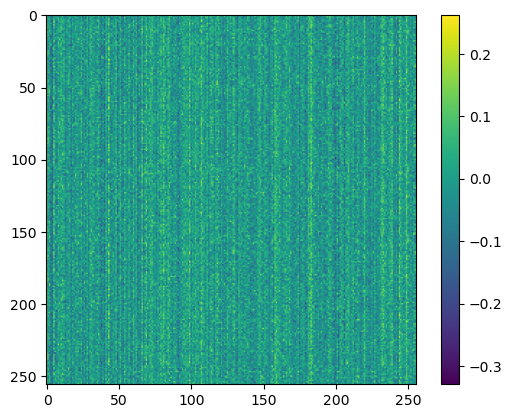

In [17]:
plt.clf()
ax = plt.gca()
img = ax.imshow(sub_latents[0:256,:])
ax.set_aspect('equal')
plt.colorbar(img)
plt.show()

# Plot a few cutouts

In [18]:
icutU = np.where(cutU)[0]

In [21]:
llcA.iloc[icutU[0]]

lat                                                         56.642715
lon                                                       -179.489578
row                                                             11455
col                                                             10456
datetime                                          2011-09-30 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                            s3://llc/PreProc/LLC_FS_preproc.h5
pp_root                                                        llc_FS
field_size                                                         64
pp_idx                                                         321195
pp_type                                                             0
mean_temperature                                             8.363781
Tmin                                                            7.244
Tmax                                                            8.835
T90                 

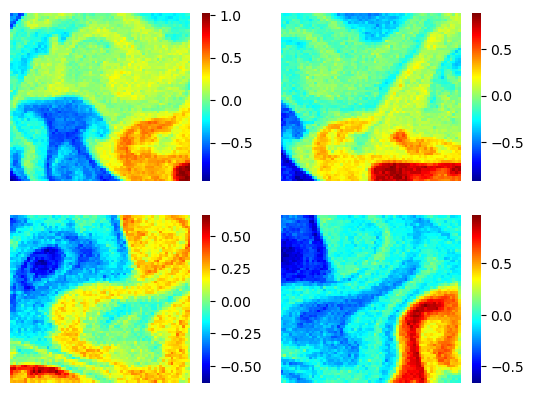

In [29]:
i0 = 10
plt.clf()

gs = gridspec.GridSpec(2,2)

for ss in range(4):
    ax = plt.subplot(gs[ss])
    cutout = llcA.iloc[icutU[ss+i0]]
    #
    img, _ = image_utils.grab_image(cutout, pp_hf=imgs_h5, close=False)
    plotting.show_image(img, ax=ax)

plt.show()

----

# Geography?

/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


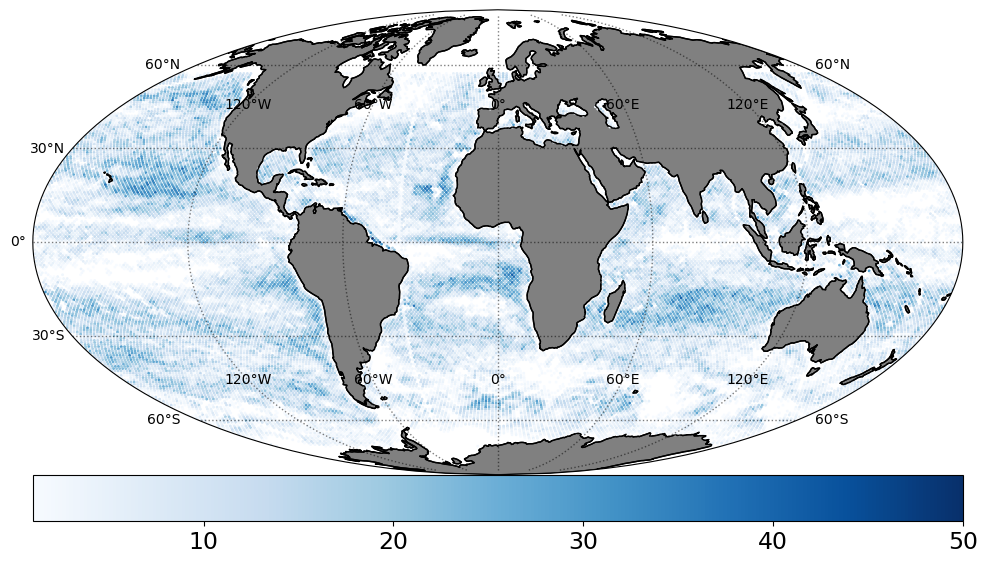

In [35]:
reload(plotting)
plotting.geo_table(llcA_cut)

/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


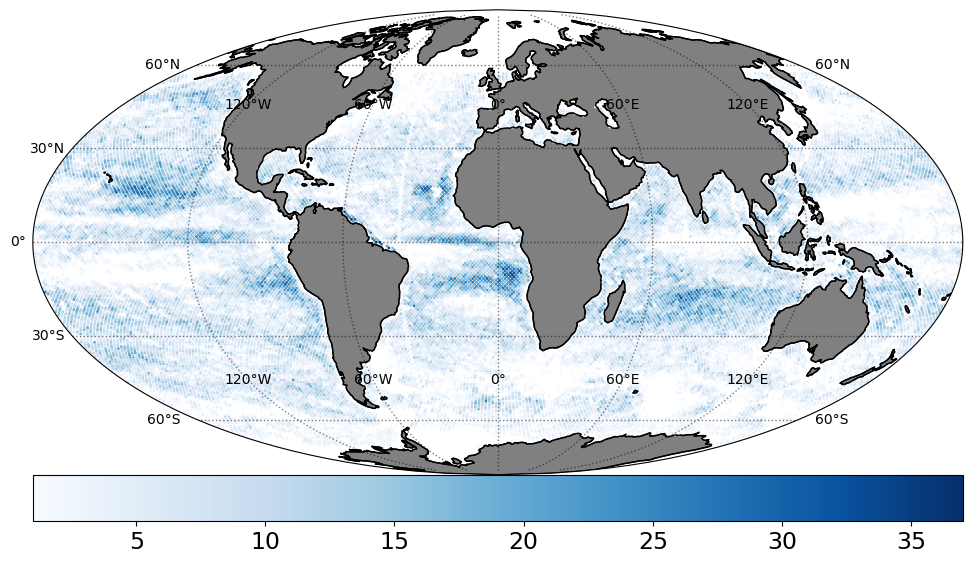

In [68]:
plotting.geo_table(llcA_counts)

## Not in the UMAP region

In [36]:
llcA_uncut = llcA[~cutU].copy()

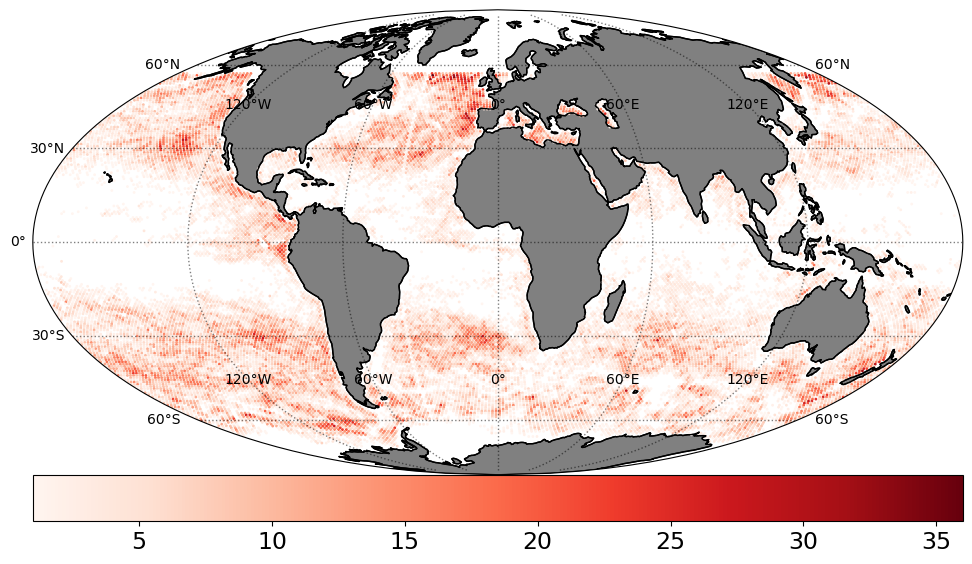

In [38]:
plotting.geo_table(llcA_uncut, color='Reds')